In [85]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import os
import time
import datetime as dt
import packages.tools as tools
import packages.models as models
import statsmodels as sms
import statsmodels.tsa as tsa
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Models:
Just like in the X-Model paper, we will use (at least) two AR(p) based models:
1. A univariate AR(p) on $X_{\text{price},t}$.
2. A 24-dimensional VAR(p) on $X_{d, h}^{\text{price}}$ for each hour $h$, where $d$ is the day.
In the paper, they search for the optimal $p$ on $\{1, 2, \ldots, 700 \}$ (up to four weeks of dependencies), and for the 24-dimensional model, they serached for the optimal order $p_h$ on $\{1, 2, \ldots, 50\}$ (up to seven weeks and one day).

If time permits, and if we encounter other ARIMA models of interest, then we will design implementations for these as well.

### Read in (pre-processed) dataset

In [8]:
path_dam_prices = "Datasets/DAMPrices.csv"
# dam_prices = tools.preprocess_price_data(path_dam_prices)
dam_prices = tools.preprocess_price_data(path_dam_prices)

In [9]:
def price_find_dst_index(time_step_id_dataframe, number_of_hours):
    if number_of_hours == 23:
        for i, time_step_id in enumerate(time_step_id_dataframe):
            if i < time_step_id:
                return(i+1)
            elif i == number_of_hours-1:
                return(23)
                
    elif number_of_hours == 25:
        for j, time_step_id in enumerate(time_step_id_dataframe):
            if j+1 > time_step_id:
                return(time_step_id)


def price_dst_adjustment(dataframe):
    df = dataframe.reset_index()
    dst_dates = df.groupby("DeliveryDay").count().loc[(df.groupby("DeliveryDay").count()["TimeStepID"] != 24),:]["TimeStepID"]
    dst_dates.rename("NumberOfHours", inplace=True)
    
    for i in range(dst_dates.shape[0]):
        dst_date = dst_dates.index[i]
        number_of_hours = dst_dates[i]
        
        # Get the price data for the specific dst_date
        df_dst_data = df.loc[df["DeliveryDay"] == dst_date,:]
        adt = df_dst_data["AuctionDateTime"].values[-1]
        
        # Find the specific hour that's either duplicated (for 25-hour days) or missing (for 23-hour days).
        dst_index = price_find_dst_index(df_dst_data["TimeStepID"], number_of_hours)
        
        # If 23-hour day, get the average of the price data for the adjacent hours.
        if number_of_hours == 23:
            # Fetch adjacent prices, e.g. if missing prices is for 3rd hour, then we fetch prices for 2nd and 4th hour.
            previous_price = df_dst_data.loc[df_dst_data["TimeStepID"] == dst_index-1]
            next_day_price = df.loc[df["DeliveryDay"] == dst_date+dt.timedelta(days=1)]
            next_price = next_day_price.loc[next_day_price["TimeStepID"] == 0]
            adjacent_prices = previous_price.append(next_price).drop(["DeliveryDay", "TimeStepID"], axis=1)
            
            # Calculate the average of the two hours of price data
            average_values = adjacent_prices.mean(axis=0).rename(df.shape[0]-1).to_frame().T
            
            # Insert this new price into the original dataframe containing reduced price data.
            identifiers = pd.DataFrame(dict(DeliveryDay=dst_date, TimeStepID=dst_index,
                                           AuctionDateTime=adt), index=[df.shape[0]-1])
            new_price = pd.concat([identifiers, average_values], axis=1)
            df = df.append(new_price)
            
        elif number_of_hours == 25:
            # Fetch duplicate prices
            duplicate_prices = df_dst_data.loc[df_dst_data["TimeStepID"] == dst_index]
            duplicate_prices.drop(["DeliveryDay", "TimeStepID"], axis=1, inplace=True)

            # Calculate the average of the two hours of price data
            average_values = duplicate_prices.mean(axis=0).rename(df.shape[0]-1).to_frame().T
            
            # Insert this new price into the original dataframe containing reduced price data.
            identifiers = pd.DataFrame(dict(DeliveryDay=dst_date, TimeStepID=dst_index,
                                            AuctionDateTime=adt), index=[df.shape[0]-1])
            new_price = pd.concat([identifiers, average_values], axis=1)
            df = df.append(new_price)
            
            # Delete the two rows of duplicate hours
            df.drop(duplicate_prices.index, inplace=True)
        
    # Sort the dataframe so that the price data is arranged in its proper order
    df.sort_values(by=["DeliveryDay", "TimeStepID"], inplace=True)
    df["DeliveryDay"] = pd.to_datetime(df["DeliveryDay"], format="%Y-%m-%d")
    
    # Reset index
    df.set_index(["DeliveryDay", "TimeStepID"], inplace=True)

    return(df)

In [10]:
dam_prices = price_dst_adjustment(dam_prices)

c:\users\nvolf\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
pd.read_csv(path_dam_prices).head()

,AreaSet,AuctionDateTime,EURGBPRate,DeliveryPeriod,IntervalDuration,EURPrices
0,SEM-DA,2018-11-11 11:00:00,0.873668,2018-11-11 23:00:00,60,55.089
1,SEM-DA,2018-11-11 11:00:00,0.873668,2018-11-12 00:00:00,60,55.120
2,SEM-DA,2018-11-11 11:00:00,0.873668,2018-11-12 01:00:00,60,46.460
3,SEM-DA,2018-11-11 11:00:00,0.873668,2018-11-12 02:00:00,60,45.710
4,SEM-DA,2018-11-11 11:00:00,0.873668,2018-11-12 03:00:00,60,41.380


In [12]:
dam_prices.head()

AuctionDateTime  EURPrices
DeliveryDay TimeStepID                               
2018-11-12  0          2018-11-11 11:00:00     55.089
            1          2018-11-11 11:00:00     55.120
            2          2018-11-11 11:00:00     46.460
            3          2018-11-11 11:00:00     45.710
            4          2018-11-11 11:00:00     41.380

## Univariate AR(p)

### First Step: Initial analysis

In [13]:
prices = dam_prices.drop("AuctionDateTime", axis=1)

In [251]:
def evaluate_stationarity(data, rolling_mean_window=5, rolling_std_window=5, acf_lags=50, pacf_lags=50, acf_vlines=[24,48],
                          pacf_vlines=[24,48], confidence=0.95):
    # Run ADF test for stationarity
    rolling_mean = data.dropna().rolling(rolling_mean_window).mean()
    rolling_std = data.dropna().rolling(rolling_std_window).std()
    ax = data.plot(figsize=(10,5), sharex=True)
    rolling_mean.plot(color='red', ax=ax)
    rolling_std.plot(color='blue', ax=ax)
    ax.legend(["Original Data", "Mean", "Standard Deviation"], loc='best')
    
    test = sm.tsa.adfuller(data.dropna())
    results = pd.Series(test[0:4], index=["Test statistic", "p-value", "No. of lags used", "No. of observations used"])
    for key, val in test[4].items():
        results[f"{key} critical value"] = val
    results["Best IC value"] = test[5]
    print("Augmented Dicky-Fuller Test Results:")    
    print(results)
    if test[1] > 1-confidence:
        print("Conclusion: Time series data is not stationary")
    else:
        print("Conclusion: Time series data is stationary")
    
    fig, ax1 = plt.subplots(1,2,figsize=(15,5))
    
    # Plot ACF
    sm.graphics.tsa.plot_acf(data.dropna(), ax=ax1[0], lags=acf_lags)
    if acf_vlines is not None:
        for lag in acf_vlines:
            ax1[0].axvline(lag, linestyle='--', linewidth=0.8, color='red')
    
    # Plot PACF
    sm.graphics.tsa.plot_pacf(data.dropna(), ax=ax1[1], lags=pacf_lags)
    if pacf_vlines is not None:
        for lag in pacf_vlines:
            ax1[1].axvline(lag, linestyle='--', linewidth=0.8, color='red')

Augmented Dicky-Fuller Test Results:
Test statistic             -7.898984e+00
p-value                     4.235033e-12
No. of lags used            4.100000e+01
No. of observations used    1.335000e+04
1% critical value          -3.430840e+00
5% critical value          -2.861757e+00
10% critical value         -2.566885e+00
Best IC value               9.489617e+04
dtype: float64
Conclusion: Time series data is stationary


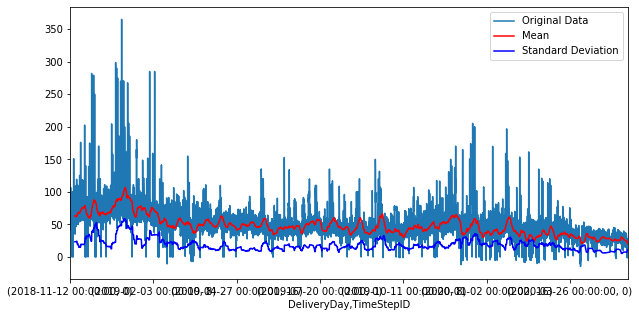

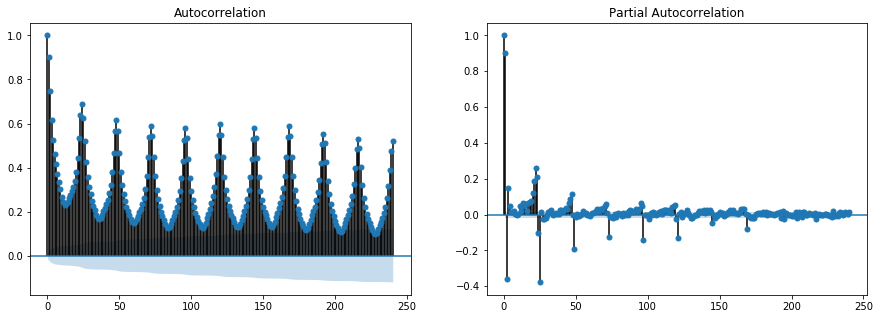

In [256]:
evaluate_stationarity(prices["EURPrices"], rolling_mean_window=120, rolling_std_window=120,
                      acf_lags=240, pacf_lags=240, acf_vlines=None, pacf_vlines=None)

In [257]:
prices["EURPrices_1h"] = prices["EURPrices"].diff()

In [258]:
prices.head()

EURPrices  EURPrices_1h  EURPrices_1h_24h
DeliveryDay TimeStepID                                           
2018-11-12  0              55.089           NaN               NaN
            1              55.120         0.031               NaN
            2              46.460        -8.660               NaN
            3              45.710        -0.750               NaN
            4              41.380        -4.330               NaN

Augmented Dicky-Fuller Test Results:
Test statistic                -26.218299
p-value                         0.000000
No. of lags used               41.000000
No. of observations used    13349.000000
1% critical value              -3.430840
5% critical value              -2.861757
10% critical value             -2.566885
Best IC value               94929.077500
dtype: float64
Conclusion: Time series data is stationary


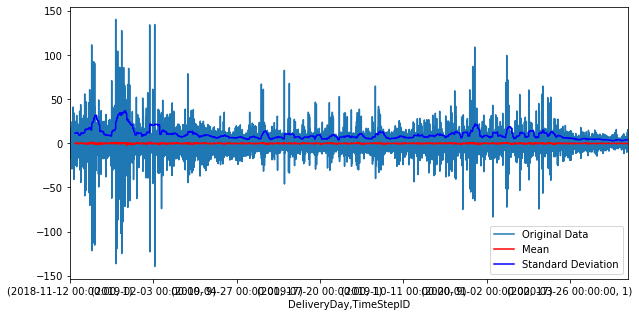

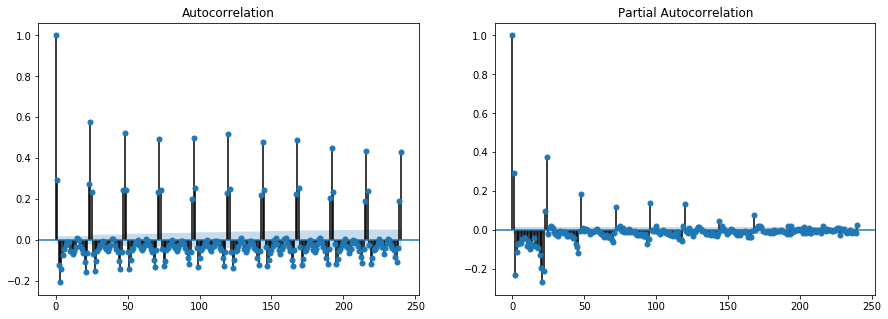

In [260]:
evaluate_stationarity(prices["EURPrices_1h"], rolling_mean_window=120, rolling_std_window=120,
                      acf_vlines=None, pacf_vlines=None, acf_lags=240, pacf_lags=240)

As expected, mean seems relatively constant (so no linear trend); variance of course is not, due to the price spikes. Although the ADF test shows stationarity, our job is far from over...

As expected from the generally known behaviour of electricity prices, the ACF shows weekly seasonality (peaks at lags 24 and 48, indicated by the red dashed vertical lines).

So, we will difference the data by 24 lags/hours.

In [261]:
prices["EURPrices_1h_24h"] = prices["EURPrices_1h"].diff(periods=24)

Augmented Dicky-Fuller Test Results:
Test statistic                -31.116291
p-value                         0.000000
No. of lags used               37.000000
No. of observations used    13329.000000
1% critical value              -3.430841
5% critical value              -2.861757
10% critical value             -2.566885
Best IC value               96265.059271
dtype: float64
Conclusion: Time series data is stationary


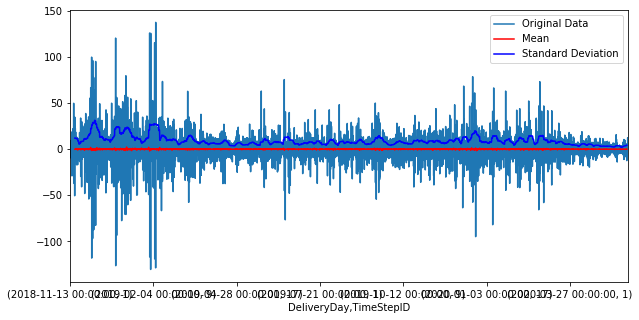

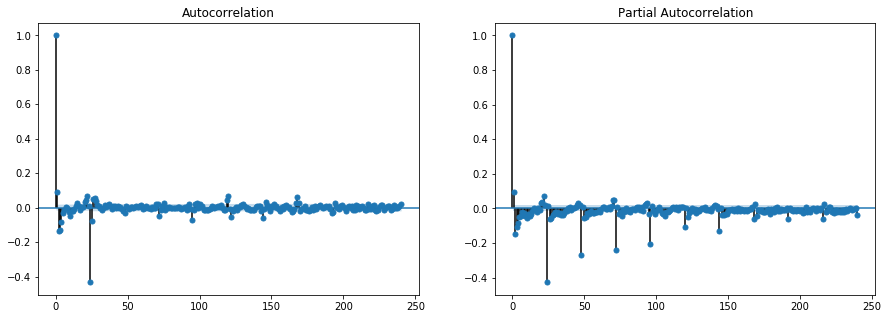

In [263]:
evaluate_stationarity(prices["EURPrices_1h_24h"], rolling_mean_window=120, rolling_std_window=120,
                      acf_vlines=None, pacf_vlines=None, acf_lags=240, pacf_lags=240)

Data looks a bit better, but there is still some seasonal behaviour at lag 24.

Augmented Dicky-Fuller Test Results:
Test statistic                -31.116291
p-value                         0.000000
No. of lags used               37.000000
No. of observations used    13329.000000
1% critical value              -3.430841
5% critical value              -2.861757
10% critical value             -2.566885
Best IC value               96265.059271
dtype: float64
Conclusion: Time series data is stationary


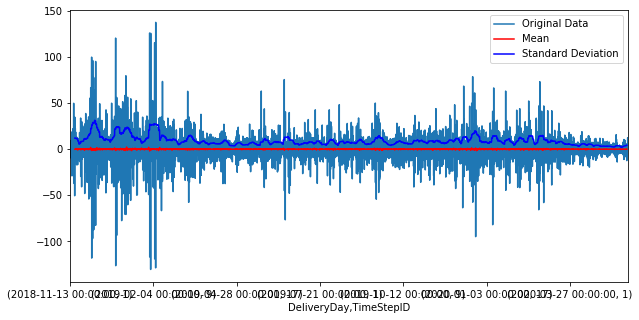

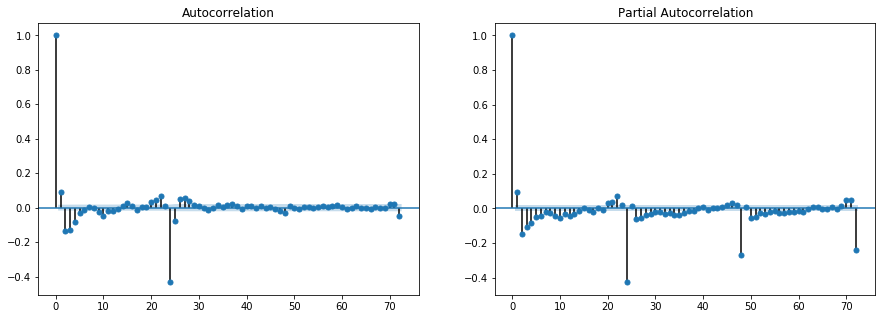

In [295]:
evaluate_stationarity(prices["EURPrices_1h_24h"], rolling_mean_window=120, rolling_std_window=120,
                      acf_vlines=None, pacf_vlines=None, acf_lags=72, pacf_lags=72)

Any further differencing doesn't seem to be useful.

Obviously (I think), this indicates that there are several dependencies that occur over days (not so much hours). After one hour differencing, most of the remaining correlation then seemed to come from a few hours before and from whole days before.

Therefore, I expect that when we train our AR(p) model, the strongest parameters affecting $t$ would be parameters $t-1, t-2, t-3, t-4$ and no further, as well as $(t-24n), n \in \mathbb{N}$ and from the hours near $(t-24n)$.

### Second Step: Finding the optimal parameter $p$

For this, we will be making use of the `statsmodels.tsa` function `AutoReg()` which fits an autoregressive (AR) time series model. But first, in order to find the optimal AR(p) model, we will need to fit an AR model for all lag combinations. However, we cannot check every parameter since there would be $2^{700}$ models to check. It wouldn't be computationally feasible. Instead, we check 700 models, i.e. AR(1), AR(2), AR(3), ..., AR(700).

It so happens that `statsmodels.tsa` has another function, `ar_select_order()` which helps to determine the optimal AR model as outlined above, so we will see if this function will be useful for us.

In [23]:
start = time.time()
test_ar = tsa.ar_model.ar_select_order(prices["EURPrices"], maxlag=700, trend='ct')
print(f"Execution time: {time.time() - start} seconds")

c:\users\nvolf\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyboardInterrupt: 

Execution time is still a bit long (more than 10 minutes), so we will just go with fitting an AR(700) model as in the paper and make a note of the parameters, as it wouldn't be feasible for example when we run the walk-forward evluation method which will require the running of the above line of code (among several other lines of code) at least a few hundred times.

In [24]:
test_ar.ar_lags

NameError: name 'test_ar' is not defined

The ar_select_order() function found the AR(121) to be the best in terms of its BIC criterion

In [25]:
test_ar1 = tsa.ar_model.AutoReg(prices["EURPrices"], lags=1)
type(test_ar1)

c:\users\nvolf\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


statsmodels.tsa.ar_model.AutoReg

In [146]:
"""
Parameters:
    data: pd.DataFrame
    target: datetime
    p: int
        AR model parameter
    trend: str
    forecast_steps: int
"""

def AR_univariate(data, target, p, trend='ct', forecast_steps=24):
    if "AuctionDateTime" in data.columns:
        data = data.drop("AuctionDateTime", axis=1)
    
    if type(target) == str:
        target = dt.datetime.strptime(target, "%Y-%m-%d")
    
    # Fit AR(p) model to data
    ar_model = tsa.ar_model.AutoReg(data, lags=p, trend=trend).fit()
    
    # Make forecasts
    n = data.shape[0]
    forecast = ar_model.predict(start=n, end=n+forecast_steps-1)
        
    # Create and prepare forecasts dataframe
    forecast_df = pd.DataFrame(dict(EURPrices=forecast), columns=["DeliveryDay", "TimeStepID","EURPrices"])
    forecast_df["TimeStepID"] = list(range(24))
    forecast_df["DeliveryDay"] = target
    forecast_df.set_index(["DeliveryDay", "TimeStepID"], inplace=True)

    return(forecast_df)

In [27]:
AR_univariate(dam_prices, dt.datetime.strptime("2018-11-12", "%Y-%m-%d"), 700)

c:\users\nvolf\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\nvolf\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


EURPrices
DeliveryDay TimeStepID           
2018-11-12  0            4.395485
            1            3.809892
            2            2.947730
            3            2.943183
            4            1.537561
            5            0.554965
            6            1.735740
            7            4.408296
            8            8.566741
            9           14.147142
            10          15.951506
            11          14.792822
            12          14.272237
            13          13.009505
            14           9.061686
            15           7.364248
            16           8.098145
            17          14.731804
            18          23.482785
            19          27.748552
            20          25.593851
            21          22.739032
            22          19.465320
            23          16.082089

## Multivariate VAR(p)

In [224]:
"""
Parameters:
    data: pd.DataFrame
    target: datetime
    p: int
        AR model parameter
    trend: str
    forecast_steps: int
"""

def AR_multivariate(data, target, p=None, trend='ct', forecast_steps=24):
    # Not yet sure how to allow for fetching fitted values (in-sample forecasts)
    if "AuctionDateTime" in data.columns:
        data = data.drop("AuctionDateTime", axis=1)

    data_copy = data.copy().reset_index("TimeStepID")
    
    # Reformat data to pass into VAR
    data_new = pd.DataFrame(columns=pd.unique(data.index.get_level_values("TimeStepID")),
                           index=pd.unique(data.index.get_level_values("DeliveryDay")))
    for column in data_new.columns:
        data_new[column] = data_copy.loc[data_copy["TimeStepID"]==column].drop("TimeStepID", axis=1)

    # Fit VAR(p) model to data
    var_model = tsa.vector_ar.var_model.VAR(data_new, freq='d')
    
    if p is None:
        p = max(var_model.select_order.values())
    
    var_fit = var_model.fit(maxlags=p)
    
    # Make forecasts
    target = data_new.index[-1] + dt.timedelta(days=1)
    forecast = var_fit.forecast(y=data_new.values, steps=1)

    # Create and prepare forecasts dataframe
    forecast_df = pd.DataFrame(dict(EURPrices=forecast[0]), columns=["DeliveryDay", "TimeStepID","EURPrices"])
    forecast_df["TimeStepID"] = list(range(24))
    forecast_df["DeliveryDay"] = target
    forecast_df.set_index(["DeliveryDay", "TimeStepID"], inplace=True)

    return(forecast_df)

In [216]:
AR_multivariate(dam_prices[:-24], "", 30)

EURPrices
DeliveryDay TimeStepID           
2020-05-22  0            7.880659
            1            4.606338
            2            3.260656
            3            6.810207
            4            9.482506
            5           11.452534
            6           15.412532
            7           19.837203
            8           20.908844
            9           22.563036
            10          27.075791
            11          26.848108
            12          27.077754
            13          25.096958
            14          28.700202
            15          25.221979
            16          30.104693
            17          45.553473
            18          50.123237
            19          54.606399
            20          48.903720
            21          36.232546
            22          36.442986
            23          35.366335

In [225]:
test1 = AR_univariate(dam_prices, dt.datetime.strptime("2020-05-22", "%Y-%m-%d"), 700)
test2 = AR_multivariate(dam_prices.iloc[0:-24], "", 50)
test1.insert(1,"Multi_50",test2)
test3 = AR_multivariate(dam_prices.iloc[0:-24], "", 18)
test1.insert(1,"Multi_18",test3)
test4 = AR_multivariate(dam_prices.iloc[0:-24], "", 1)
test1.insert(1,"Multi_1",test4)
test_df = test1
test_df.columns=["Uni","Multi_50", "Multi_18","Multi_1"]

c:\users\nvolf\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\nvolf\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


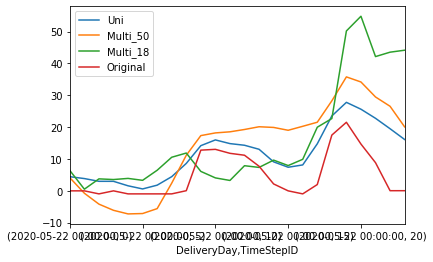

In [226]:
test_df["Original"] = dam_prices.loc["2020-05-22"]["EURPrices"]
test_df.drop(["Multi_1"],axis=1).plot()